In [112]:
import nltk 
from nltk.tokenize import sent_tokenize, word_tokenize, WhitespaceTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
lemma = WordNetLemmatizer()
pstem = PorterStemmer()
lemma.lemmatize('madness'), pstem.stem('madness')

('madness', 'mad')

In [3]:
import os
import numpy as np
import pandas as pd
print(os.listdir("C:\AppFolder\PG ML\Masters_LJMU\DataInput"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [4]:
nltk.corpus.wordnet.fileids()

('cntlist.rev',
 'lexnames',
 'index.sense',
 'index.adj',
 'index.adv',
 'index.noun',
 'index.verb',
 'data.adj',
 'data.adv',
 'data.noun',
 'data.verb',
 'adj.exc',
 'adv.exc',
 'noun.exc',
 'verb.exc')

In [5]:
df_train=pd.read_csv('C:\AppFolder\PG ML\Masters_LJMU\DataInput/train.csv')
df_test=pd.read_csv('C:\AppFolder\PG ML\Masters_LJMU\DataInput/test.csv')
df_subm=pd.read_csv('C:\AppFolder\PG ML\Masters_LJMU\DataInput/sample_submission.csv')

In [6]:
df_train.shape, df_test.shape

((30336, 17), (29272, 16))

In [7]:
df_train.isnull().sum()

ID                    0
Place                 0
location          11254
date                  0
status                0
job_title             0
summary              52
positives             0
negatives             0
advice_to_mgmt    13277
score_1            3186
score_2            6050
score_3            3169
score_4            3191
score_5            3485
score_6               0
overall               0
dtype: int64

In [8]:
df_test.isnull().sum()

ID                    0
Place                 0
location           9625
date                  0
status                0
job_title             0
summary              51
positives             0
negatives             1
advice_to_mgmt    12519
score_1               0
score_2               0
score_3               0
score_4               0
score_5               0
score_6               0
dtype: int64

In [9]:
col = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6']
for c in col:
    df_train[c].fillna(df_train[c].dropna().median(), inplace=True)
    df_test[c].fillna(df_train[c].dropna().median(), inplace=True)

df_train['advice_to_mgmt'].fillna('', inplace=True)
df_test['advice_to_mgmt'].fillna('', inplace=True)

df_train.dropna(subset=['negatives','summary'], inplace=True)
df_test.dropna(subset=['negatives','summary'], inplace=True)

In [10]:
df_train.shape, df_test.shape

((30284, 17), (29220, 16))

In [11]:
drop_col = ['ID', 'location', 'date']
df_train.drop(columns=drop_col, inplace=True)
df_test.drop(columns=drop_col, inplace=True)

In [12]:
df_train.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall
84,startup_1,Former Employee,Video Producer,Challenging and rewarding work,Very transparent company despite its size. Man...,No real complaints. I wish I could've stayed.,,5.0,5.0,5.0,5.0,5.0,0,5.0
18647,startup_2,Former Employee,Mac Genius,Genius,"Great people, good pay, benefits, supporting t...","never enough staffing, 1 person doing 3 jobs, ...",Don't let someone become a manager just becaus...,4.0,5.0,5.0,5.0,5.0,3,4.0
592,startup_1,Former Employee,Analyst,Awesome company,nice food and facilities are awesome.,nothing much to say. Everything was perfect,,5.0,5.0,5.0,5.0,5.0,0,4.0
23170,startup_6,Former Employee,Group Product Manager,First seven years were great. Last several yea...,Stock awards were good. Good professional trai...,Too many hours worked. Perf reviews were a jok...,Hire more women!,1.0,1.0,2.0,3.0,1.0,0,4.0
1560,startup_1,Former Employee,Anonymous Employee,"Great company culture, not enough opportunity ...","Excellent perks, especially opportunity to lea...",Not enough opportunity for growth. Very hierar...,,5.0,5.0,2.0,4.0,3.0,1,3.0


In [13]:
df_test.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6
7145,startup_4,Current Employee,Anonymous Employee,Fulfillment Associate,Great benefit package. I enjoy working 4 days ...,Must make rate and rate expected keeps increas...,,2,2,2,3,2,0
15789,startup_5,Current Employee,Software Engineer,The best first job I could have ever thought of.,"Super smart colleagues, inspiring goals, high ...",None that I can think of.,,5,5,5,5,4,0
7408,startup_4,Current Employee,Anonymous Employee,Love Amazon,"Fast pace, always moving...innovative and fun","Physically hard on body, long hours",,3,5,5,4,4,1
12774,startup_4,Current Employee,Team Leader,Team Leader,Wonderful working environment for every level ...,Downside in carrier Opportunities for lower le...,Nothing,3,3,3,3,5,0
13341,startup_4,Current Employee,Senior Catalog Associate,Senior Associate,Good Place to Work without pressure,Higher Management Seems to be changing which a...,,5,5,5,5,1,0


In [14]:
def Review_len(df):
    df['len_pos'] = df['positives'].str.len()
    df['len_neg'] = df['negatives'].str.len()
    df['len_sum'] = df['summary'].str.len()
    df['advice_to_mgmt'] = df['advice_to_mgmt'].str.len()

In [15]:
Review_len(df_train)
Review_len(df_test)

In [16]:
df_train.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall,len_pos,len_neg,len_sum
15694,startup_5,Current Employee,Software Engineer,Awesome place to work,- really smart people to work with - culture o...,"- none, really - there are a couple of old tim...",80,5.0,5.0,5.0,5.0,5.0,0,4.0,150,293,21
2710,startup_1,Current Employee,Anonymous Employee,The best company I have ever worked at,"The people, the environment, the work itself, ...",Google has become a huge company and it is bec...,129,4.0,5.0,5.0,5.0,5.0,0,4.0,179,195,38
22785,startup_6,Former Employee,Anonymous Employee,Good experience - Lots of people cuts and change,Good place to work - especially if you are wor...,Teams not working on current initiatives can s...,0,2.0,2.0,3.0,3.0,2.0,0,2.0,78,121,48
16487,startup_2,Current Employee,Business Expert,Business Expert,"Best schedule in the business, a consistent M-...","Way too many tasks to complete, constantly cal...",97,4.0,2.0,5.0,5.0,4.0,1,5.0,77,110,15
20272,startup_2,Current Employee,Specialist,Best Employer I've Had So Far.,"Great training, excellent benefits, fun enviro...","Poor communication, and training is impossible...",0,5.0,5.0,4.0,4.0,4.0,0,5.0,74,128,30


In [17]:
df_test.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,len_pos,len_neg,len_sum
4587,startup_4,Current Employee,Principal Product Management,The best Company I have worked for.,Great company. Awesome people. Great and impac...,I have really no complaints. Middle management...,169,4,5,5,5,5,0,166,135,35
7183,startup_4,Current Employee,Picker,Decent,Good pay that anyone who works hard can make,"The work is very hard, the hours are long, exp...",38,2,3,3,2,2,0,44,68,6
28473,startup_6,Current Employee,Technical Advisor,Great Company with amazing benefits,Employee friendly company with amazing work cu...,I work for Microsoft India and it's lacking th...,123,4,4,4,5,2,0,125,206,35
17504,startup_2,Current Employee,Anonymous Employee,Great Retail Job,great benefits and pay for retail,micromanagement and terrible customers sometimes,14,4,5,5,5,2,0,33,48,16
6796,startup_4,Current Employee,Senior Program Manager,Sr. Program Manager,This is the most innovative environments I hav...,There is a lot of ambiguity and the environmen...,0,4,5,5,4,5,2,436,274,19


In [18]:
def ChangeToInt(df,col):
    df[col]=df[col].astype('int')

In [19]:
label='overall'
ChangeToInt(df_train,label)


In [20]:
def show_wordcloud(data, title = None):
    V_wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 7
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(V_wordcloud)
    plt.show()

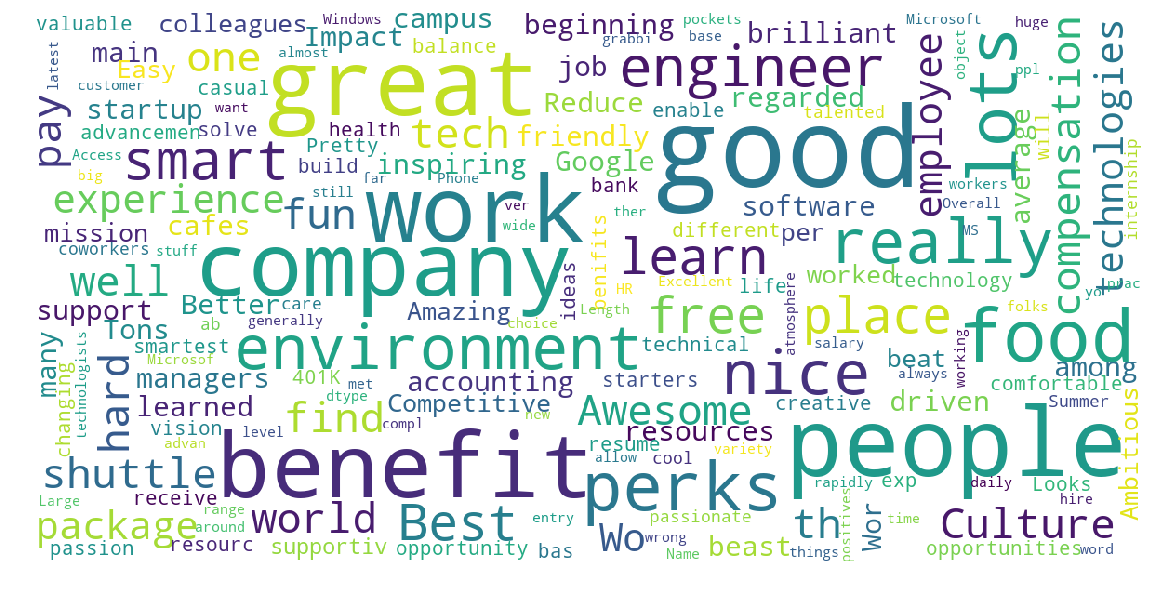

In [21]:
# print positive wordcloud
show_wordcloud(df_train["positives"])

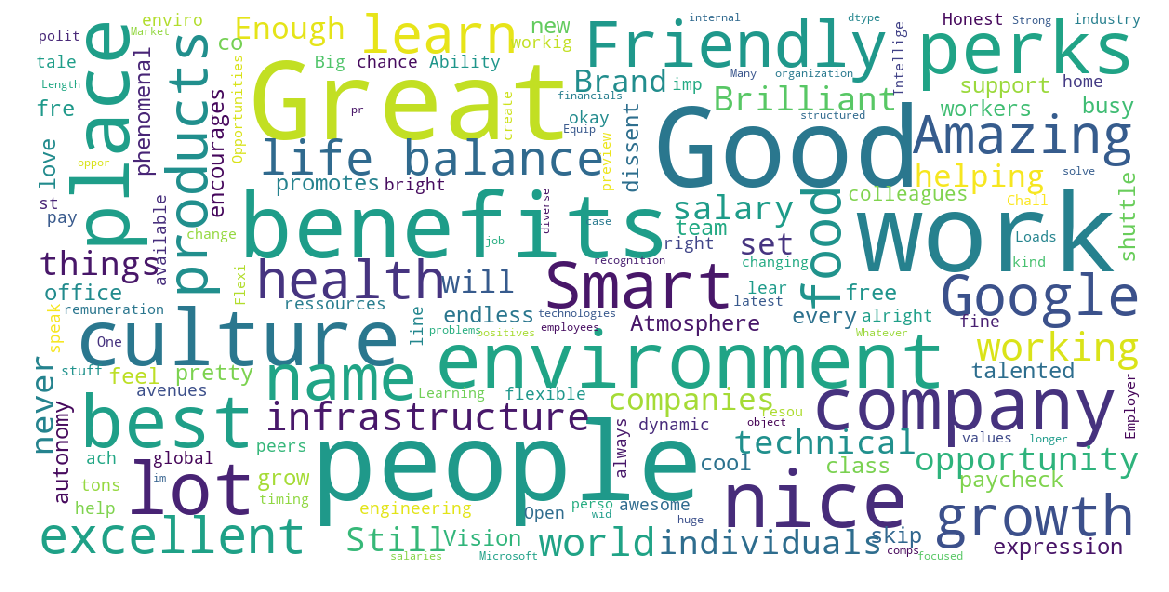

In [22]:
# print positive wordcloud
show_wordcloud(df_test["positives"])

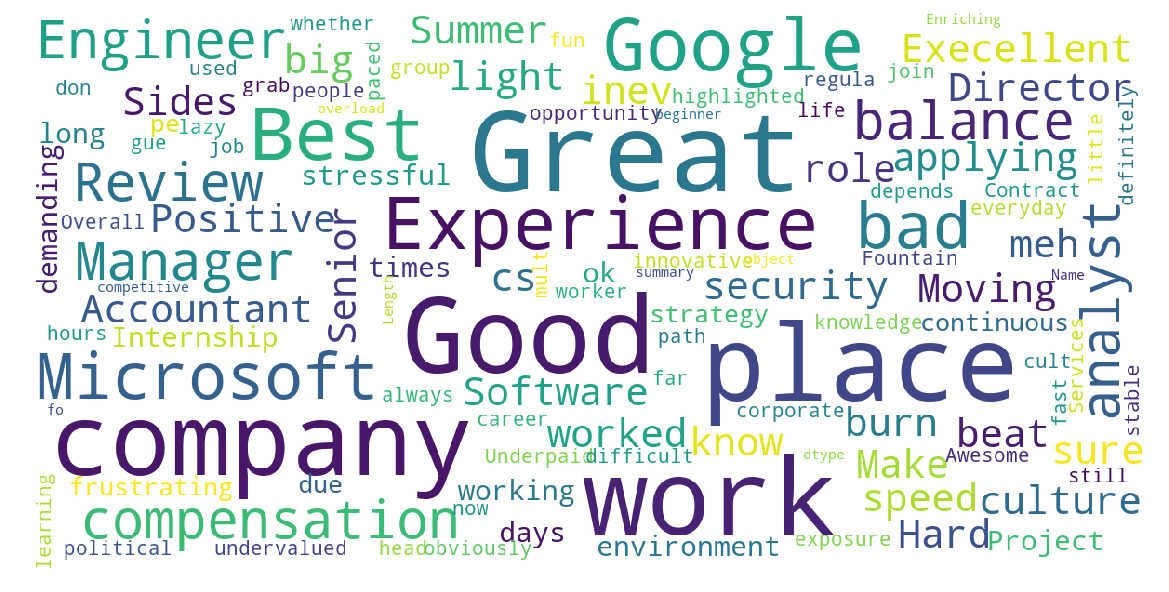

In [23]:
show_wordcloud(df_train["summary"])

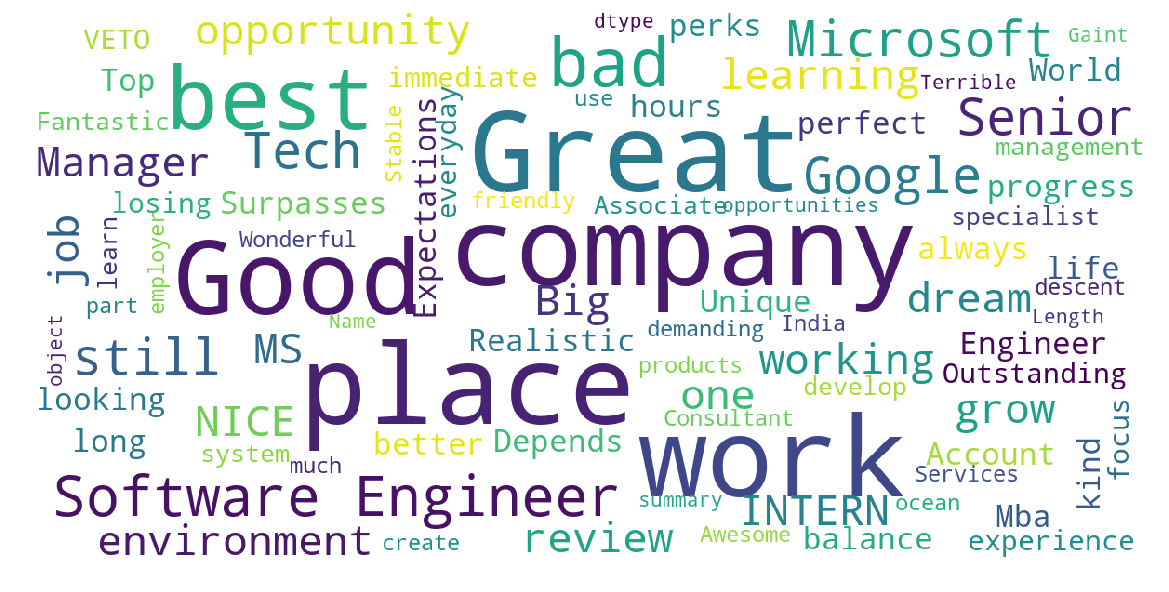

In [24]:
show_wordcloud(df_test["summary"])

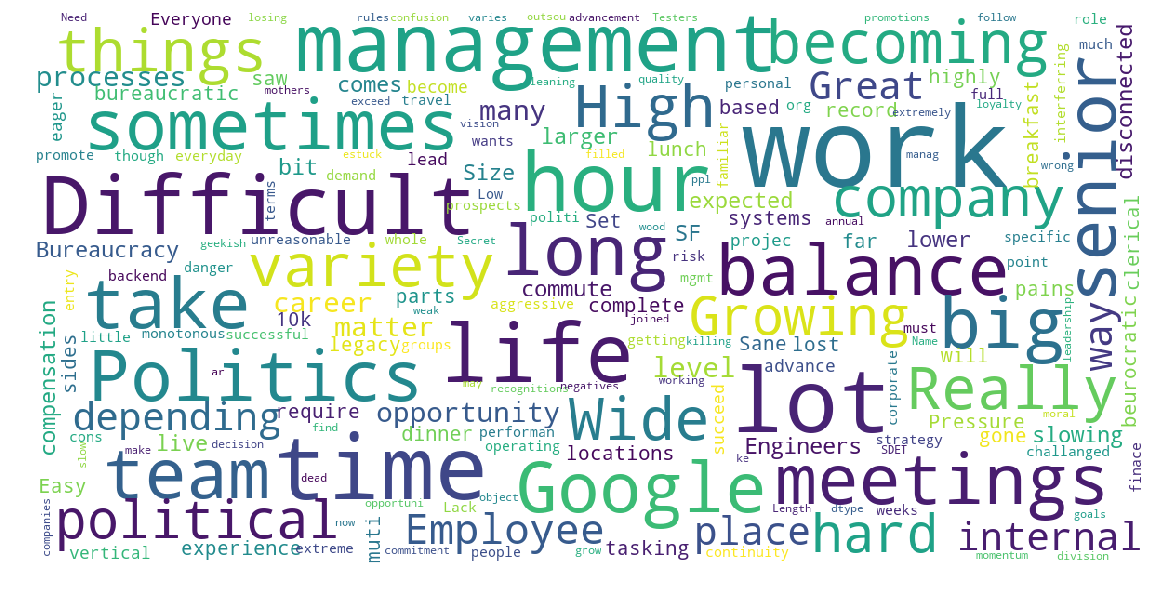

In [25]:
show_wordcloud(df_train["negatives"])

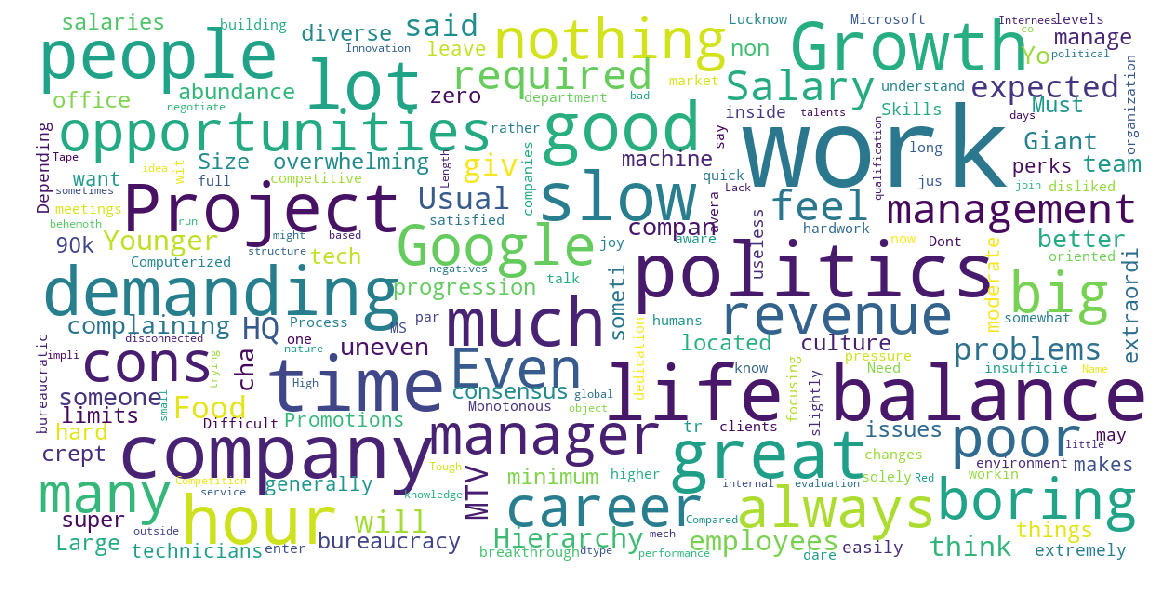

In [26]:
show_wordcloud(df_test["negatives"])

In [27]:
df_train["combined_review_text"] = df_train["positives"].str.cat(df_train[["negatives", "summary"]].astype(str), sep=" ")
df_train.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall,len_pos,len_neg,len_sum,combined_review_text
1607,startup_1,Current Employee,Senior Software Engineer,"Friendly, brilliant people",Great community atmosphere. Brilliant engineer...,Gets a bit political as you climb up the ladde...,0,4.0,5.0,5.0,5.0,4.0,5,3,625,86,26,Great community atmosphere. Brilliant engineer...
1527,startup_1,Former Employee,Operations Engineer I,"Challenging, fun, and high stress.",Some of the best perks and benefits available ...,Life work balance is nonexistent. Middle manag...,77,1.0,4.0,2.0,5.0,4.0,1,3,205,174,34,Some of the best perks and benefits available ...
9094,startup_4,Current Employee,Startup Project Manager,Project Manager,Unlimited growth potential. You can do as much...,Always changing so some people can't keep up a...,12,4.0,5.0,5.0,4.0,4.0,0,3,124,115,15,Unlimited growth potential. You can do as much...
25824,startup_6,Former Employee,Group Manager,Group Manager,"Smart people, challenging work. Benefits quite...",Can be hard to find a top quality manager to w...,0,2.0,4.0,3.0,4.0,3.0,0,4,58,68,13,"Smart people, challenging work. Benefits quite..."
17937,startup_2,Former Employee,Redzone Specialist,Specialist,"It was a great working environment, fast paced...","Being such a large company, it could be diffic...",128,3.0,4.0,3.0,3.0,4.0,0,4,221,147,10,"It was a great working environment, fast paced..."


In [28]:
df_test["combined_review_text"] = df_test["positives"].str.cat(df_test[["negatives", "summary"]].astype(str), sep=" ")
df_test.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,len_pos,len_neg,len_sum,combined_review_text
28103,startup_6,Current Employee,Anonymous Employee,Great place to work!,Good work-personal life balance and flexibilit...,"the offices are in 2 separate buildings, one i...",0,5,5,4,5,5,0,311,148,20,Good work-personal life balance and flexibilit...
20651,startup_2,Current Employee,Senior Advisor,Concerned about the direction Apple is headed in.,Work from home opportunities and some schedule...,Apple seems to be losing some of the qualities...,292,3,3,3,3,3,4,173,354,49,Work from home opportunities and some schedule...
19301,startup_2,Current Employee,Anonymous Employee,Good Company,"Good salary, good environment and good colleag...","No free food, and cubic offices are not open.",0,5,4,4,4,4,0,50,45,12,"Good salary, good environment and good colleag..."
13010,startup_4,Current Employee,CSA,CSA,Great place to work and grow.,Didnot find any Cons as of now.,0,5,5,5,5,5,0,29,31,3,Great place to work and grow. Didnot find any ...
15708,startup_5,Current Employee,Recruiting Lead,Empowered to Do What I Love,#1: The people. The flexibility. The challenge...,"Depending where you live, the commute - but th...",14,5,5,5,5,5,0,95,85,27,#1: The people. The flexibility. The challenge...


In [29]:
df_train.isnull().sum()

Place                   0
status                  0
job_title               0
summary                 0
positives               0
negatives               0
advice_to_mgmt          0
score_1                 0
score_2                 0
score_3                 0
score_4                 0
score_5                 0
score_6                 0
overall                 0
len_pos                 0
len_neg                 0
len_sum                 0
combined_review_text    0
dtype: int64

In [30]:
df_test.isnull().sum()

Place                   0
status                  0
job_title               0
summary                 0
positives               0
negatives               0
advice_to_mgmt          0
score_1                 0
score_2                 0
score_3                 0
score_4                 0
score_5                 0
score_6                 0
len_pos                 0
len_neg                 0
len_sum                 0
combined_review_text    0
dtype: int64

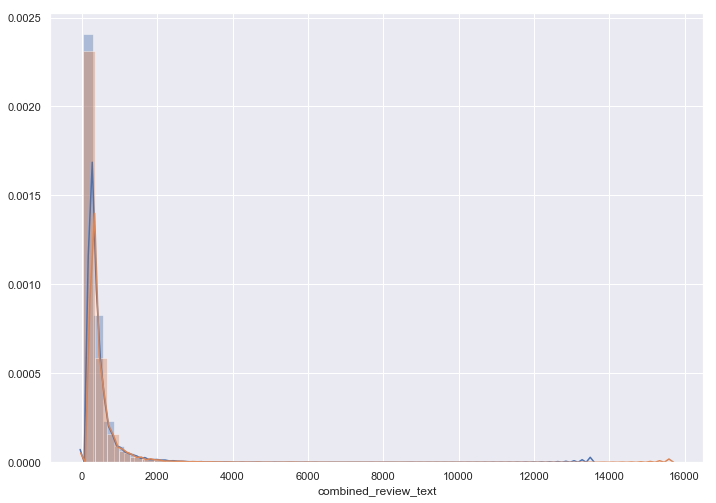

In [31]:
#Length distribution in text
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df_train['combined_review_text'].str.len(), hist=True, label="combined_review_text")
sns.distplot(df_test['combined_review_text'].str.len(), hist=True, label="combined_review_text")
#sns.distplot(df_test.len_pos, hist=True, label="positives");

In [32]:
#Number of words distribution
df_train['number_words'] = df_train['combined_review_text'].apply(lambda x: len(x.split()))
df_test['number_words'] = df_test['combined_review_text'].apply(lambda x: len(x.split()))

In [33]:
df_train['number_words'].mean()

56.41678774270242

In [34]:
df_test['number_words'].mean()

56.62539356605065

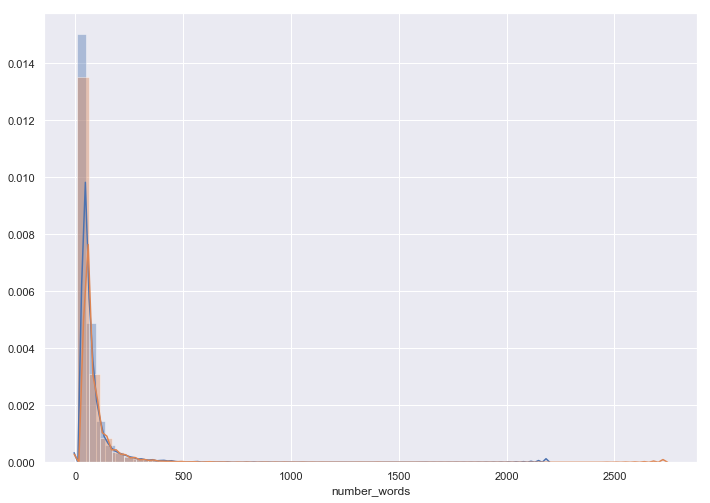

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df_train['number_words'], hist=True, label="train")
sns.distplot(df_test['number_words'], hist=True, label="test");

In [36]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
data = df_train['combined_review_text']
print("Using TFIDF Vectorizer to produce Sparse Matrix of Features")
t0 = time()

tf_idf_vectorizor = TfidfVectorizer(max_df=0.5,
                                 min_df=5,stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 30000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
print("done in %fs" % (time() - t0))

Using TFIDF Vectorizer to produce Sparse Matrix of Features
done in 1.725049s


In [37]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,00,000,10,100,1000,100k,100s,101,10am,10hr,...,zuck,zuckerberg,zune,ça,école,équilibre,équipe,équipes,évolution,être
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
from textblob import TextBlob
words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there","all","we",
                "one","the","a","an","of","or","in","for","by","on","but","is","in","a","not","with","as",
                "was","if","they","are","this","and","it","have","has","from","at","my","be","by","not","that","to",
                "from","com","org","like","likes","so","said","from","what","told","over","more","other",
                "have","last","with","this","that","such","when","been","says","will","also","where","why",
                "would","today", "in", "on", "you", "r", "d", "u", "hw","wat", "oly", "s", "b", "ht", 
                "rt", "p","the","th", "n", "was"]


def cleantext(df, words_to_remove = words_remove): 
    ### dont change the original tweet
    # remove emoticons form the tweets
    df['combined_review_text'] = df['combined_review_text'].replace(r'<ed>','', regex = True)
    df['combined_review_text'] = df['combined_review_text'].replace(r'\B<U+.*>|<U+.*>\B|<U+.*>','', regex = True)
    
    # convert tweets to lowercase
    df['combined_review_text'] = df['combined_review_text'].str.lower()
    
    #remove user mentions
    df['combined_review_text'] = df['combined_review_text'].replace(r'^(@\w+)',"", regex=True)
    
    #remove 'rt' in the beginning
    df['combined_review_text'] = df['combined_review_text'].replace(r'^(rt @)',"", regex=True)
    
    #remove_symbols
    df['combined_review_text'] = df['combined_review_text'].replace(r'[^a-zA-Z0-9]', " ", regex=True)

    #remove punctuations 
    df['combined_review_text'] = df['combined_review_text'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}]+',"", regex = True)
    #remove_numbers
    df['combined_review_text'] = df['combined_review_text'].str.replace(r'\d+','')

    #remove_URL(x):
    df['combined_review_text'] = df['combined_review_text'].replace(r'https.*$', "", regex = True)

    #remove 'amp' in the text
    df['combined_review_text'] = df['combined_review_text'].replace(r'amp',"", regex = True)
    
    #remove words of length 1 or 2 
    df['combined_review_text'] = df['combined_review_text'].replace(r'\b[a-zA-Z]{1,2}\b','', regex=True)

    #remove extra spaces in the tweet
    df['combined_review_text'] = df['combined_review_text'].replace(r'^\s+|\s+$'," ", regex=True)
    #Spelling correction
    #df['combined_review_text'] = df['combined_review_text']..apply(lambda x: str(TextBlob(x).correct()))
     
    
    #remove stopwords and words_to_remove
    stop_words = set(stopwords.words('english'))
    mystopwords = [stop_words, "via", words_to_remove]
    
    df['cleaned_review_text'] = df['combined_review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in mystopwords]))
    

    return df

In [39]:
df_train = cleantext(df_train)

In [40]:
df_test = cleantext(df_test)

In [41]:
df_train.shape, df_test.shape

((30284, 20), (29220, 19))

In [42]:
df_train=df_train[:29220]

In [43]:
df_train.shape, df_test.shape

((29220, 20), (29220, 19))

In [44]:
df_train.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall,len_pos,len_neg,len_sum,combined_review_text,number_words,cleaned_review_text
17692,startup_2,Current Employee,Visuals Lead,GREAT CULTURE,work with some of the coolest people great wor...,ability to move up very busy environment some ...,208,5.0,5.0,3.0,5.0,3.0,0,3,95,65,13,work with some the coolest people great work ...,28,work with some the coolest people great work c...
5316,startup_4,Former Employee,Fresh Associate/Seasonal Fulfillment Associate,Former Fresh and Fulfillment,Flexible work hours Water always available,Unrealistic work parameters Salary Unsanitary ...,235,3.5,4.0,1.0,1.0,3.0,2,2,42,175,28,flexible work hours water always available unr...,37,flexible work hours water always available unr...
9169,startup_4,Current Employee,At Home Customer Service Representative,at home csr,"hours, pay, convenience, training, simplicity","discount, lack of organization,my office smell...",24,5.0,5.0,5.0,3.0,5.0,0,4,45,56,11,hours pay convenience training simplicity ...,16,hours pay convenience training simplicity disc...
22505,startup_6,Current Employee,Senior Program Manager,Great place to work,"Benefits, colleagues, management, location, co...",no cons or downsides observed,0,3.0,5.0,5.0,5.0,4.0,0,5,56,29,19,benefits colleagues management location co...,14,benefits colleagues management location compen...
27777,startup_6,Former Employee,Sales Representative,Don't believe the Hype - it is not a Great pla...,"Some smart people, good salary",too many bullies in management and a leadershi...,14,2.0,2.0,4.0,4.0,1.0,0,1,30,81,56,some smart people good salary too many bullie...,32,some smart people good salary too many bullies...


In [45]:
df_test.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,len_pos,len_neg,len_sum,combined_review_text,number_words,cleaned_review_text
12591,startup_4,Current Employee,Anonymous Employee,4+ years in Amazon India,"Good work environment, friendly people, learn ...","lots of politics, you need to out perform the ...",62,4,3,4,4,3,0,78,128,24,good work environment friendly people learn ...,40,good work environment friendly people learn ne...
16016,startup_5,Current Employee,Lead Security Counsel,Review Title,Mission. Culture. People. Managers. Feedback.,Nothing to highlight so far,0,5,5,5,5,5,0,45,27,12,mission culture people managers feedback ...,12,mission culture people managers feedback nothi...
24086,startup_6,Current Employee,Anonymous Employee,depends on what you are doing,"Good benefits, good work life balance. indepen...","too much politics, stock not that good, salary...",0,4,3,3,4,3,0,87,60,29,good benefits good work life balance indepen...,28,good benefits good work life balance independe...
20739,startup_2,Former Employee,At Home Advisor,at home advisor,"sleep thru my shift, and training","errythang, it was no fun.",21,1,1,1,1,1,3,33,25,15,sleep thru shift and training errythang wa...,14,sleep thru shift and training errythang was fu...
13962,startup_4,Former Employee,SDE1,Great Experience,They have a nice work environment,The work load can be too much at times,36,4,5,4,4,3,0,33,38,16,they have nice work environment the work load...,17,they have nice work environment the work load ...


In [46]:
#More pre-processing
from nltk.stem.wordnet import WordNetLemmatizer
import re
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def more_refine_text(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    processed = re.sub(r"\d+","",normalized)
    y = processed.split()
    return y

In [47]:
df_train["cleaned_review_text"] = df_train["cleaned_review_text"].apply(lambda x: more_refine_text(x))
df_test["cleaned_review_text"] = df_test["cleaned_review_text"].apply(lambda x: more_refine_text(x))

In [48]:
df_train.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall,len_pos,len_neg,len_sum,combined_review_text,number_words,cleaned_review_text
2353,startup_1,Current Employee,Anonymous Employee,goal,it is very good company,working hours are too long,0,3.5,4.0,4.0,4.0,3.0,0,4,23,26,4,very good company working hours are too long ...,11,"[good, company, working, hour, long, goal]"
18373,startup_2,Current Employee,Anonymous Employee,Great Benefits,Working from home gives a lot of flexibility.,There aren't really any cons except for the lo...,0,5.0,5.0,3.0,5.0,4.0,0,4,45,98,14,working from home gives lot flexibility the...,29,"[working, home, give, lot, flexibility, really..."
4998,startup_4,Current Employee,Process Guide,Decent place to work,"Great Pay, Easy to move up in the company, ver...","Micromanaged, tons of dumb people, short shift...",129,4.0,5.0,5.0,4.0,4.0,1,5,103,136,20,great pay easy move the company very rela...,45,"[great, pay, easy, move, company, relaxed, pla..."
12498,startup_4,Former Employee,Anonymous Employee,"Nice exposture,could learn a lot","enjoyed a lot,good environment to learn everyt...","i didn't find anything , good place to work",0,4.0,5.0,4.0,4.0,4.0,0,2,82,43,32,enjoyed lot good environment learn everythin...,28,"[enjoyed, lot, good, environment, learn, every..."
15220,startup_4,Current Employee,Anonymous Employee,Bonne entreprise quand on veut s'investir,"Opportunités d volition, salaire et bonne ambi...",Beaucoup d'investissements nécessaires pour év...,0,3.0,5.0,4.0,4.0,4.0,1,4,50,51,41,opportunit volition salaire bonne ambiance...,18,"[opportunit, volition, salaire, bonne, ambianc..."


In [49]:
# Set values for various parameters
num_features = 100    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size  

In [50]:
# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(df_train["cleaned_review_text"], workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)

# If you don't plan to train the model any further, calling 
#init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

C:\AppFolder\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Training model...


In [51]:
#Find vector corresponding to each text
#Take the average of all word vectors in a text
import numpy as np
vocab = list(model.wv.vocab)
def sentence_vector(sentence, model):
    nwords = 0
    featureV = np.zeros(100, dtype="float32")
    for word in sentence:
        if word not in vocab:
            continue
        featureV = np.add(featureV, model[word])
        nwords = nwords + 1
    if nwords > 0: 
        featureV = np.divide(featureV, nwords)
    return featureV

text_vector = df_train["cleaned_review_text"].apply(lambda x: sentence_vector(x, model))  

text_vector = text_vector.apply(pd.Series)

In [52]:
#test data

text_test_vector = df_test["cleaned_review_text"].apply(lambda x: sentence_vector(x, model))  

text_test_vector = text_test_vector.apply(pd.Series)

In [53]:
#Text vector should vary from 0 to 1 (normalize the vector)
for x in range(len(text_vector)):
    x_min = text_vector.iloc[x].min()
    x_max = text_vector.iloc[x].max()
    X  = text_vector.iloc[x]
    i = 0
    if (x_max - x_min) == 0:
        for y in X:
            text_vector.iloc[x][i] = (1/len(text_vector.iloc[x]))
            i = i + 1
    else:
        for y in X:
            text_vector.iloc[x][i] = ((y - x_min)/(x_max - x_min))
            i = i + 1

In [54]:
#Text vector should vary from 0 to 1 (normalize the vector)
for y in range(len(text_test_vector)):
    y_min = text_test_vector.iloc[y].min()
    y_max = text_test_vector.iloc[y].max()
    Y  = text_test_vector.iloc[y]
    i = 0
    if (y_max - x_min) == 0:
        for z in Y:
            text_test_vector.iloc[y][i] = (1/len(text_test_vector.iloc[y]))
            i = i + 1
    else:
        for z in Y:
            text_test_vector.iloc[y][i] = ((z - y_min)/(y_max - y_min))
            i = i + 1

In [55]:
print(text_vector.shape)
print(X.shape)

(29220, 100)
(100,)


In [56]:
print(text_test_vector.shape)
print(Y.shape)

(29220, 100)
(100,)


In [57]:
#Sentiment Analysis
from textblob import TextBlob
df_train['sentiment'] = df_train['combined_review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)  #-1 to 1

In [58]:
#Sentiment Analysis

df_test['sentiment'] = df_test['combined_review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)  #-1 to 1

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

range_n_clusters = [4, 5, 6, 7, 8, 9, 10, 11]
X = text_vector
n_best_clusters = 0
silhouette_best = 0
for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++',random_state=1000)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels,metric='euclidean',sample_size = 1000)
                                      #, sample_size = 5000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    if silhouette_avg > silhouette_best:
        silhouette_best = silhouette_avg
        n_best_clusters = n_clusters

For n_clusters = 4 The average silhouette_score is : 0.11972395
For n_clusters = 5 The average silhouette_score is : 0.09809992
For n_clusters = 6 The average silhouette_score is : 0.09379265
For n_clusters = 7 The average silhouette_score is : 0.093421936
For n_clusters = 8 The average silhouette_score is : 0.08675664
For n_clusters = 9 The average silhouette_score is : 0.08086771
For n_clusters = 10 The average silhouette_score is : 0.07496671
For n_clusters = 11 The average silhouette_score is : 0.07360089


In [60]:
cluster_labels

array([8, 0, 0, ..., 6, 2, 1])

In [61]:
n_best_clusters

4

In [62]:
clusterer = KMeans(n_clusters= n_best_clusters , random_state=10)
cluster_labels = clusterer.fit_predict(X)

In [63]:
np.unique(cluster_labels)  

array([0, 1, 2, 3])

In [64]:
df_train['cl_num'] = cluster_labels

In [65]:
clusters = clusterer.labels_.tolist()

In [66]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

poor_cluster_indices = []
avg_cluster_sil_score = []

for i in range(n_best_clusters):
# Aggregate the silhouette scores for samples belonging to
# cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        avgscore = (np.mean(ith_cluster_silhouette_values))   #average silhouette score for each cluster
        avg_cluster_sil_score = np.append(avg_cluster_sil_score, avgscore)
        print('Cluster',i, ':', avgscore)
        if avgscore < 0.07:
            poor_cluster_indices = np.append(poor_cluster_indices, i)
            
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

Cluster 0 : 0.05343763
Cluster 1 : 0.17760701
Cluster 2 : 0.12777771
Cluster 3 : 0.09313104


In [67]:
poor_cluster_indices

array([0.])

In [68]:
#Array of texts, the corresponding cluster number, sentiment
finaldf = pd.DataFrame({'cl_num': cluster_labels,'combined_review_text': df_train['combined_review_text'], 'cleaned_review_text': df_train['cleaned_review_text'],'sentiment': df_train['sentiment']})
finaldf = finaldf.sort_values(by=['cl_num'])

In [69]:
df_train['cl_num'] = cluster_labels

In [70]:
df_train

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,...,score_6,overall,len_pos,len_neg,len_sum,combined_review_text,number_words,cleaned_review_text,sentiment,cl_num
0,startup_1,Current Employee,Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,0,4.0,5.0,5.0,...,0,5,29,34,24,people are smart and friendly bureaucracy slo...,15,"[people, smart, friendly, bureaucracy, slowing...",0.358433,2
1,startup_1,Former Employee,Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1004,2.0,3.0,3.0,...,2094,5,1048,2403,52,food food food cafes main cus mtv alo...,563,"[food, food, food, cafe, main, cu, mtv, alone,...",0.089528,1
2,startup_1,Current Employee,Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",56,5.0,4.0,5.0,...,949,5,3634,1064,72,you software engineer you among the kings...,814,"[software, engineer, among, king, hill, google...",0.130210,1
3,startup_1,Current Employee,Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,295,2.0,5.0,5.0,...,498,4,1572,2614,55,you can find more well regarded company that...,790,"[find, well, regarded, company, actually, dese...",0.166404,1
4,startup_1,Current Employee,Anonymous Employee,Execellent for engineers,Impact driven. Best tech in the world.,Size matters. Engineers are a bit disconnected...,0,5.0,5.0,5.0,...,0,4,38,62,24,impact driven best tech the world size matt...,19,"[impact, driven, best, tech, world, size, matt...",1.000000,2
5,startup_1,Current Employee,Anonymous Employee,Review,The people are great to work with,There is lower compensation than expected,0,3.5,4.0,4.0,...,0,5,33,41,6,the people are great work with there lower c...,14,"[people, great, work, lower, compensation, exp...",0.350000,0
6,startup_1,Current Employee,Anonymous Employee,Review of Google,"The people are great to work with, good perks.",Wide variety in experience based on team.,0,4.0,5.0,5.0,...,2,3,46,41,16,the people are great work with good perks w...,19,"[people, great, work, good, perk, wide, variet...",0.466667,0
7,startup_1,Former Employee,Anonymous Employee,Analysts,"Good managers, benefits , some support, nice a...","Long hours, far locations, a lot of work",0,3.5,4.0,2.0,...,1,5,55,40,8,good managers benefits some support nice a...,17,"[good, manager, benefit, support, nice, atmosp...",0.337500,0
8,startup_1,Former Employee,Anonymous Employee,Great Company With No Down Sides,Really fun work environment with startup,Really no down sides that I saw.,0,5.0,5.0,5.0,...,1,5,40,32,32,really fun work environment with startup reall...,19,"[really, fun, work, environment, startup, real...",0.197222,0
9,startup_1,Current Employee,Anonymous Employee,Software Engineer,Awesome job environment to work in,Pressure is there for some parts,0,3.5,4.0,4.0,...,0,5,34,32,17,awesome job environment work pressure there...,14,"[awesome, job, environment, work, pressure, pa...",1.000000,0


In [101]:
dfOrdered = pd.DataFrame(df_train)

In [102]:
#Compute how many times a text  - that is, how many rows in dfOrdered are identical
dfOrdered['cleaned_review_text'] = dfOrdered['cleaned_review_text'].apply(tuple)
dfUnique = dfOrdered.groupby(['combined_review_text','sentiment','cleaned_review_text', 'cl_num']).size().reset_index(name="freq")
dfUnique = dfUnique.sort_values(by=['cl_num'])

In [103]:
dfUnique['cleaned_review_text'] = dfUnique['cleaned_review_text'].apply(list)
dfOrdered['cleaned_review_text'] = dfOrdered['cleaned_review_text'].apply(list)

In [104]:
dfUnique

,combined_review_text,sentiment,cleaned_review_text,cl_num,freq
14520,great benefits work life balance and pay for...,0.289484,"[great, benefit, work, life, balance, pay, pos...",0,1
17688,great work environment and friendly coworkers ...,0.418750,"[great, work, environment, friendly, coworkers...",0,1
7551,compensation fair work interesting and opp...,0.300000,"[compensation, fair, work, interesting, opport...",0,1
17689,great work environment and fun management coul...,0.533333,"[great, work, environment, fun, management, co...",0,1
17690,great work environment and fun works room mo...,0.550000,"[great, work, environment, fun, work, room, mo...",0,1
17691,great work environment and good encouragement ...,0.442308,"[great, work, environment, good, encouragement...",0,1
17693,great work environment and people pay and grea...,0.800000,"[great, work, environment, people, pay, great,...",0,1
17696,great work environment and what not lots and...,0.400000,"[great, work, environment, lot, financial, ana...",0,1
7544,compensation career opportunity quality peo...,0.100000,"[compensation, career, opportunity, quality, p...",0,1
7543,compensation benefits and discounts well th...,0.255556,"[compensation, benefit, discount, well, compan...",0,1


In [75]:
text_consider = 'combined_review_text'

In [76]:
final_clusters = np.unique(dfUnique['cl_num'])
print(final_clusters)

[0 1 2 3]


In [77]:
#Store all reviews corresponding to each cluster in a file
for i in final_clusters:
    with open('./review_Cluster_'+str(i)+'.txt','w') as out:
        y = ''
        for x in dfUnique[text_consider][dfUnique.cl_num == i]:    
            y = y + x + '. '
        out.write(y)
        out.close()

In [119]:
File = open('./review_Cluster_0.txt', 'r') #open file
lines = File.read() #read all lines
sentences = nltk.sent_tokenize(lines) #tokenize sentences

In [122]:
# tokenize using gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
#data = df['reviews.text'].values.tolist()
data_words = list(sent_to_words(sentences))

In [123]:
# sample
print(data_words[3])

['great', 'work', 'environment', 'and', 'fun', 'management', 'could', 'have', 'more', 'transparency', 'with', 'the', 'employees', 'trms']


In [124]:
# create list of stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)

In [125]:
# functions for removing stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [126]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

In [127]:
# call functions

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# initialize spacy 'en' model, use only tagger since we don't need parsing or NER 
# python3 -m spacy download en nlp = spacy.load("en_core_web_sm")

#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['great', 'work', 'environment', 'fun', 'management', 'transparency', 'employee', 'trm']


In [128]:
# create dictionary and corpus
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[2])

[(0, 1), (2, 1), (5, 1), (8, 1), (15, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]


In [129]:
# human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('balance', 1),
  ('benefit', 2),
  ('company', 1),
  ('enough', 1),
  ('get', 1),
  ('great', 2),
  ('hard', 1),
  ('large', 2),
  ('life', 1),
  ('lose', 1),
  ('make', 1),
  ('movement', 1),
  ('pay', 1),
  ('position', 1),
  ('vertical', 1),
  ('work', 1)]]

In [133]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [134]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.36654234105139577


In [153]:
# print the 10 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.128*"work" + 0.069*"good" + 0.053*"great" + 0.035*"company" + '
  '0.035*"people" + 0.029*"place" + 0.022*"environment" + 0.021*"lot" + '
  '0.019*"life" + 0.018*"balance"'),
 (1,
  '0.051*"love" + 0.032*"feel" + 0.032*"pretty" + 0.029*"ever" + 0.022*"stock" '
  '+ 0.021*"option" + 0.016*"poor" + 0.015*"home" + 0.015*"role" + '
  '0.012*"young"'),
 (2,
  '0.069*"benefit" + 0.045*"pay" + 0.037*"hour" + 0.036*"job" + 0.034*"great" '
  '+ 0.028*"amazing" + 0.023*"awesome" + 0.021*"long" + 0.017*"management" + '
  '0.016*"time"')]


In [135]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.332869  0.033043       1        1  69.793533
2      0.134356 -0.273671       2        1  24.877598
1      0.198514  0.240629       3        1   5.328871, topic_info=     Category         Freq         Term        Total  loglift  logprob
15    Default  8286.000000         work  8286.000000  30.0000  30.0000
1     Default  1595.000000      benefit  1595.000000  29.0000  29.0000
44    Default  4454.000000         good  4454.000000  28.0000  28.0000
12    Default  1043.000000          pay  1043.000000  27.0000  27.0000
78    Default   849.000000         hour   849.000000  26.0000  26.0000
188   Default   821.000000          job   821.000000  25.0000  25.0000
62    Default   640.000000      amazing   640.000000  24.0000  24.0000
2     Default  2273.000000      company  2273.000000  23.0000  23.0000
24    Default  2231.000000       people  2231.000000  22.0000  22.0000
131   Default   250.000000         love   250.000000  21.0000  21.0000
102   Default   536.000000      awesome   536.000000  20.0000  20.0000
224   Default   481.000000         long   481.000000  19.0000  19.0000
118   Default  1896.000000        place  1896.000000  18.0000  18.0000
37    Default   402.000000   management   402.000000  17.0000  17.0000
469   Default   160.000000         feel   160.000000  16.0000  16.0000
182   Default   342.000000       always   342.000000  15.0000  15.0000
542   Default   156.000000       pretty   156.000000  14.0000  14.0000
52    Default  1339.000000          lot  1339.000000  13.0000  13.0000
66    Default   325.000000       retail   325.000000  12.0000  12.0000
17    Default  1448.000000  environment  1448.000000  11.0000  11.0000
8     Default  1231.000000         life  1231.000000  10.0000  10.0000
35    Default   378.000000     employee   378.000000   9.0000   9.0000
477   Default   142.000000         ever   142.000000   8.0000   8.0000
36    Default   557.000000          fun   557.000000   7.0000   7.0000
0     Default  1140.000000      balance  1140.000000   6.0000   6.0000
119   Default   736.000000         time   736.000000   5.0000   5.0000
253   Default   276.000000         move   276.000000   4.0000   4.0000
5     Default  4185.000000        great  4185.000000   3.0000   3.0000
214   Default   245.000000          day   245.000000   2.0000   2.0000
307   Default   108.000000        stock   108.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
542    Topic3   155.815964       pretty   156.637985   2.9268  -3.4554
477    Topic3   141.950928         ever   142.781189   2.9262  -3.5486
307    Topic3   107.996254        stock   108.789223   2.9247  -3.8220
513    Topic3   102.278389       option   103.032761   2.9247  -3.8764
455    Topic3    80.906448         poor    81.670662   2.9226  -4.1108
534    Topic3    75.735954         home    76.470802   2.9224  -4.1768
479    Topic3    72.650642         role    73.397720   2.9218  -4.2184
443    Topic3    52.883789  expectation    53.639637   2.9178  -4.5360
599    Topic3    59.918812        young    60.775459   2.9178  -4.4111
548    Topic3    55.262444        limit    56.135292   2.9164  -4.4920
129    Topic3    44.463329        bonus    45.207031   2.9154  -4.7094
133    Topic3    44.817120        value    45.568542   2.9154  -4.7015
448    Topic3    44.935280         look    45.736347   2.9144  -4.6988
610    Topic3    44.739182        train    45.602062   2.9129  -4.7032
292    Topic3    38.884781         term    39.640388   2.9128  -4.8435
621    Topic3    41.620037     overtime    42.433517   2.9127  -4.7755
76     Topic3    35.871281         edge    36.604870   2.9118  -4.9241
614    Topic3    33.140331        brand    33.833706   2.9113  -5.0033
535    Topic3    36.313267        never    37.117676   2.9101  -4.9119
779    Topic3    34.856468       talent    35.688843   2.9084  -4.

In [141]:
File = open('./review_Cluster_1.txt', 'r') #open file
lines01 = File.read() #read all lines
sentences_01 = nltk.sent_tokenize(lines01) #tokenize sentences


In [142]:
data_words_01 = list(sent_to_words(sentences_01))

In [143]:
# functions for removing stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [144]:
# remove stop words
data_words_nostops_01 = remove_stopwords(data_words_01)

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized_01 = lemmatization(data_words_nostops_01, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# create dictionary and corpus
# create dictionary
id2word_01 = corpora.Dictionary(data_lemmatized_01)

# Create corpus
corpus_01 = [id2word_01.doc2bow(text) for text in data_lemmatized_01]

In [147]:
# Build LDA model
lda_model_01 = gensim.models.ldamodel.LdaModel(corpus=corpus_01,
                                           id2word=id2word_01,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [148]:
# coherence score
coherence_model_lda_01 = CoherenceModel(model=lda_model_01, texts=data_lemmatized_01, dictionary=id2word_01, coherence='c_v')
coherence_lda_01 = coherence_model_lda_01.get_coherence()
print('\nCoherence Score: ', coherence_lda_01)


Coherence Score:  0.3425309846973919


In [152]:
#
#Let's now print the topics found in the dataset.
# print the 10 topics
import string, pprint
pprint.pprint(lda_model_01.print_topics())
doc_lda = lda_model_01[corpus_01]

[(0,
  '0.022*"get" + 0.020*"people" + 0.018*"time" + 0.015*"make" + 0.013*"thing" '
  '+ 0.012*"job" + 0.012*"year" + 0.012*"day" + 0.012*"take" + 0.010*"want"'),
 (1,
  '0.052*"work" + 0.029*"good" + 0.026*"company" + 0.022*"great" + '
  '0.014*"team" + 0.013*"employee" + 0.012*"management" + 0.011*"benefit" + '
  '0.011*"manager" + 0.011*"lot"'),
 (2,
  '0.021*"performance" + 0.012*"metric" + 0.012*"associate" + 0.011*"review" + '
  '0.011*"chance" + 0.010*"fire" + 0.008*"rate" + 0.008*"rank" + '
  '0.007*"turnover" + 0.006*"force"')]


In [149]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_01, corpus_01, id2word_01)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.192113  0.224402       1        1  62.465054
0     -0.137874 -0.250417       2        1  31.028349
2      0.329987  0.026015       3        1   6.506602, topic_info=     Category          Freq         Term         Total  loglift  logprob
98    Default  14926.000000         work  14926.000000  30.0000  30.0000
35    Default   8183.000000         good   8183.000000  29.0000  29.0000
13    Default   7496.000000      company   7496.000000  28.0000  28.0000
117   Default   6299.000000        great   6299.000000  27.0000  27.0000
33    Default   4037.000000          get   4037.000000  26.0000  26.0000
87    Default   1904.000000        thing   1904.000000  25.0000  25.0000
90    Default   3854.000000         time   3854.000000  24.0000  24.0000
401   Default   1656.000000          day   1656.000000  23.0000  23.0000
53    Default   2862.000000         make   2862.000000  22.0000  22.0000
114   Default   1746.000000         take   1746.000000  21.0000  21.0000
86    Default   3963.000000         team   3963.000000  20.0000  20.0000
350   Default    632.000000  performance    632.000000  19.0000  19.0000
65    Default   5340.000000       people   5340.000000  18.0000  18.0000
717   Default    862.000000       review    862.000000  17.0000  17.0000
95    Default   1478.000000         want   1478.000000  16.0000  16.0000
221   Default   1410.000000         even   1410.000000  15.0000  15.0000
202   Default   3242.000000      benefit   3242.000000  14.0000  14.0000
46    Default   1290.000000         know   1290.000000  13.0000  13.0000
135   Default   3199.000000          lot   3199.000000  12.0000  12.0000
156   Default   2595.000000          job   2595.000000  11.0000  11.0000
82    Default   1155.000000          see   1155.000000  10.0000  10.0000
320   Default   3576.000000   management   3576.000000   9.0000   9.0000
50    Default   2599.000000         life   2599.000000   8.0000   8.0000
276   Default   2740.000000         year   2740.000000   7.0000   7.0000
79    Default   1022.000000          say   1022.000000   6.0000   6.0000
88    Default   1018.000000        think   1018.000000   5.0000   5.0000
131   Default   1318.000000         give   1318.000000   4.0000   4.0000
183   Default   1134.000000         come   1134.000000   3.0000   3.0000
509   Default    739.000000       system    739.000000   2.0000   2.0000
96    Default   1038.000000          way   1038.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
1924   Topic3    140.478714       vendor    141.275452   2.7267  -5.3475
1823   Topic3    144.452179       rating    145.274948   2.7267  -5.3196
3041   Topic3    129.163544     contract    129.932358   2.7264  -5.4315
2145   Topic3    115.219467   supervisor    115.976753   2.7258  -5.5457
997    Topic3    114.081413         fear    114.914864   2.7251  -5.5556
1468   Topic3     99.353966         tier    100.115234   2.7247  -5.6938
656    Topic3     91.436539         wage     92.153038   2.7245  -5.7769
1561   Topic3    138.882080       nearly    139.998566   2.7243  -5.3589
1534   Topic3     90.305054    assistant     91.038673   2.7243  -5.7893
1499   Topic3     94.590889        floor     95.366531   2.7242  -5.7430
634    Topic3    113.625252       pocket    114.579025   2.7240  -5.5596
1660   Topic3     92.497681        model     93.336647   2.7233  -5.7654
560    Topic3    323.584656       chance    326.538910   2.7233  -4.5131
1591   Topic3     92.855370       dental     93.703728   2.7233  -5.7615
1526   Topic3     92.716545        awful     93.591469   2.7230  -5.7630
1330   Topic3     82.626869   repetitive     83.437622   2.7226  -5.8782
1601   Topic3     83.310509         send     84.128723   2.7226  -5.8700
677    Topic3     79.452728       safety     80.240906   2.7225  -5.9174
562    Topic3    104.312614         f

In [154]:
File = open('./review_Cluster_2.txt', 'r') #open file
lines02 = File.read() #read all lines
sentences_02 = nltk.sent_tokenize(lines02) #tokenize sentences

In [155]:
data_words_02 = list(sent_to_words(sentences_02))

In [156]:
# remove stop words
data_words_nostops_02 = remove_stopwords(data_words_02)

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized_02 = lemmatization(data_words_nostops_02, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# create dictionary and corpus
# create dictionary
id2word_02 = corpora.Dictionary(data_lemmatized_02)

# Create corpus
corpus_02 = [id2word_02.doc2bow(text) for text in data_lemmatized_02]

In [157]:
# Build LDA model
lda_model_02 = gensim.models.ldamodel.LdaModel(corpus=corpus_02,
                                           id2word=id2word_02,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [158]:
# coherence score
coherence_model_lda_02 = CoherenceModel(model=lda_model_02, texts=data_lemmatized_02, dictionary=id2word_02, coherence='c_v')
coherence_lda_02 = coherence_model_lda_02.get_coherence()
print('\nCoherence Score: ', coherence_lda_02)


Coherence Score:  0.4497018243751252


In [159]:
#Let's now print the topics found in the dataset.
# print the 10 topics
import string, pprint
pprint.pprint(lda_model_02.print_topics())
doc_lda = lda_model_02[corpus_02]

[(0,
  '0.052*"work" + 0.037*"company" + 0.032*"great" + 0.025*"good" + 0.021*"lot" '
  '+ 0.018*"opportunity" + 0.016*"team" + 0.014*"benefit" + 0.013*"manager" + '
  '0.012*"learn"'),
 (1,
  '0.052*"people" + 0.017*"business" + 0.016*"focus" + 0.014*"high" + '
  '0.013*"politic" + 0.013*"drive" + 0.012*"much" + 0.011*"take" + '
  '0.011*"culture" + 0.010*"lack"'),
 (2,
  '0.040*"customer" + 0.038*"innovative" + 0.034*"leadership" + 0.014*"fun" + '
  '0.014*"think" + 0.013*"service" + 0.013*"hire" + 0.010*"retail" + '
  '0.010*"encourage" + 0.010*"love"')]


In [160]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_02, corpus_02, id2word_02)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.267873  0.173194       1        1  66.721085
1      0.044992 -0.281062       2        1  23.424984
2     -0.312865  0.107869       3        1   9.853936, topic_info=     Category         Freq         Term        Total  loglift  logprob
23    Default  3594.000000       people  3594.000000  30.0000  30.0000
34    Default  6619.000000         work  6619.000000  29.0000  29.0000
99    Default   760.000000     customer   760.000000  28.0000  28.0000
7     Default  4669.000000      company  4669.000000  27.0000  27.0000
17    Default   706.000000   innovative   706.000000  26.0000  26.0000
40    Default  4023.000000        great  4023.000000  25.0000  25.0000
72    Default   640.000000   leadership   640.000000  24.0000  24.0000
179   Default   774.000000     business   774.000000  23.0000  23.0000
57    Default  3152.000000         good  3152.000000  22.0000  22.0000
251   Default   697.000000        focus   697.000000  21.0000  21.0000
464   Default  2323.000000  opportunity  2323.000000  20.0000  20.0000
71    Default   797.000000         high   797.000000  19.0000  19.0000
368   Default   572.000000        drive   572.000000  18.0000  18.0000
159   Default   727.000000      politic   727.000000  17.0000  17.0000
211   Default   738.000000         much   738.000000  16.0000  16.0000
263   Default  2777.000000          lot  2777.000000  15.0000  15.0000
133   Default   525.000000         take   525.000000  14.0000  14.0000
52    Default  2049.000000         team  2049.000000  13.0000  13.0000
142   Default  1734.000000      benefit  1734.000000  12.0000  12.0000
206   Default   508.000000         lack   508.000000  11.0000  11.0000
440   Default   262.000000          fun   262.000000  10.0000  10.0000
19    Default   498.000000        level   498.000000   9.0000   9.0000
63    Default   261.000000        think   261.000000   8.0000   8.0000
375   Default   454.000000     internal   454.000000   7.0000   7.0000
89    Default  1509.000000        learn  1509.000000   6.0000   6.0000
129   Default   244.000000      service   244.000000   5.0000   5.0000
125   Default  1704.000000      manager  1704.000000   4.0000   4.0000
66    Default   239.000000         hire   239.000000   3.0000   3.0000
73    Default  1394.000000        place  1394.000000   2.0000   2.0000
81    Default  1400.000000    challenge  1400.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
129    Topic3   243.473465      service   244.365952   2.3136  -4.3440
66     Topic3   238.305115         hire   239.200394   2.3135  -4.3654
99     Topic3   757.138123     customer   760.191101   2.3133  -3.2094
26     Topic3   192.882431       retail   193.675156   2.3132  -4.5769
532    Topic3   189.446945    encourage   190.334488   2.3126  -4.5949
355    Topic3   185.240860       create   186.142960   2.3124  -4.6173
94     Topic3   176.077026         self   176.958832   2.3123  -4.6680
614    Topic3   161.596436    principle   162.421585   2.3122  -4.7539
1107   Topic3   150.538300     position   151.361267   2.3118  -4.8247
309    Topic3   175.887161    potential   176.863968   2.3118  -4.6691
77     Topic3   142.982300       vision   143.910706   2.3108  -4.8762
760    Topic3   131.477859        never   132.353302   2.3107  -4.9601
3      Topic3   118.355186        apple   119.171883   2.3104  -5.0653
716    Topic3   116.053383       demand   116.915123   2.3099  -5.0849
353    Topic3   113.546829    associate   114.391884   2.3099  -5.1067
108    Topic3   102.971466   specialist   103.805054   2.3092  -5.2045
9      Topic3    99.665848     creative   100.481598   2.3091  -5.2371
1222   Topic3    96.443298        truly    97.275299   2.3087  -5.2700
223    Topic3   100.738281      startup   101.649033   2.3083  -5.2264
775    Topic3   118.347977        speed   119.462776   2.3079  -5.

In [161]:
File = open('./review_Cluster_3.txt', 'r') #open file
lines03 = File.read() #read all lines
sentences_03 = nltk.sent_tokenize(lines03) #tokenize sentences

In [162]:
data_words_03 = list(sent_to_words(sentences_03))

In [163]:
# remove stop words
data_words_nostops_03 = remove_stopwords(data_words_03)

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized_03 = lemmatization(data_words_nostops_03, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# create dictionary and corpus
# create dictionary
id2word_03 = corpora.Dictionary(data_lemmatized_03)

# Create corpus
corpus_03 = [id2word_03.doc2bow(text) for text in data_lemmatized_03]

In [164]:
# Build LDA model
lda_model_03 = gensim.models.ldamodel.LdaModel(corpus=corpus_03,
                                           id2word=id2word_03,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [165]:
# coherence score
coherence_model_lda_03 = CoherenceModel(model=lda_model_03, texts=data_lemmatized_03, dictionary=id2word_03, coherence='c_v')
coherence_lda_03 = coherence_model_lda_03.get_coherence()
print('\nCoherence Score: ', coherence_lda_03)


Coherence Score:  0.49822264150667434


In [166]:
#Let's now print the topics found in the dataset.
# print the 10 topics
import string, pprint
pprint.pprint(lda_model_03.print_topics())
doc_lda = lda_model_03[corpus_03]

[(0,
  '0.035*"retail" + 0.029*"customer" + 0.020*"people" + 0.019*"apple" + '
  '0.017*"fun" + 0.016*"amazing" + 0.014*"product" + 0.013*"store" + '
  '0.013*"discount" + 0.013*"busy"'),
 (1,
  '0.032*"break" + 0.022*"get" + 0.017*"rate" + 0.015*"walk" + 0.015*"minute" '
  '+ 0.014*"hire" + 0.013*"start" + 0.012*"make" + 0.012*"take" + 0.009*"say"'),
 (2,
  '0.064*"work" + 0.031*"time" + 0.030*"pay" + 0.029*"hour" + 0.027*"great" + '
  '0.026*"job" + 0.021*"good" + 0.018*"benefit" + 0.017*"day" + '
  '0.014*"employee"')]


In [167]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_03, corpus_03, id2word_03)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.276173  0.128410       1        1  68.141495
1     -0.012369 -0.275771       2        1  20.079344
0     -0.263804  0.147361       3        1  11.779163, topic_info=     Category         Freq         Term        Total  loglift  logprob
5     Default  4476.000000         work  4476.000000  30.0000  30.0000
32    Default   714.000000        break   714.000000  29.0000  29.0000
90    Default   421.000000       retail   421.000000  28.0000  28.0000
13    Default  2198.000000         time  2198.000000  27.0000  27.0000
46    Default  2114.000000          pay  2114.000000  26.0000  26.0000
23    Default  2061.000000         hour  2061.000000  25.0000  25.0000
161   Default   349.000000     customer   349.000000  24.0000  24.0000
22    Default  1918.000000        great  1918.000000  23.0000  23.0000
7     Default  1216.000000          get  1216.000000  22.0000  22.0000
9     Default  1799.000000          job  1799.000000  21.0000  21.0000
88    Default  1168.000000       people  1168.000000  20.0000  20.0000
289   Default   347.000000         rate   347.000000  19.0000  19.0000
8     Default  1438.000000         good  1438.000000  18.0000  18.0000
243   Default   317.000000         walk   317.000000  17.0000  17.0000
283   Default   311.000000       minute   311.000000  16.0000  16.0000
82    Default   230.000000        apple   230.000000  15.0000  15.0000
15    Default  1287.000000      benefit  1287.000000  14.0000  14.0000
78    Default   313.000000         hire   313.000000  13.0000  13.0000
85    Default   207.000000          fun   207.000000  12.0000  12.0000
12    Default   388.000000        start   388.000000  11.0000  11.0000
321   Default   192.000000      amazing   192.000000  10.0000  10.0000
364   Default   229.000000     discount   229.000000   9.0000   9.0000
122   Default   483.000000         take   483.000000   8.0000   8.0000
101   Default   480.000000         make   480.000000   7.0000   7.0000
447   Default   171.000000      product   171.000000   6.0000   6.0000
73    Default   163.000000        store   163.000000   5.0000   5.0000
67    Default   157.000000         busy   157.000000   4.0000   4.0000
162   Default   458.000000  environment   458.000000   3.0000   3.0000
615   Default   193.000000         back   193.000000   2.0000   2.0000
55    Default   295.000000       worker   295.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
539    Topic3   110.147095     pressure   110.952461   2.1316  -4.6972
611    Topic3   117.046371        staff   117.911644   2.1315  -4.6365
456    Topic3    98.307785         poor    99.077240   2.1310  -4.8109
182    Topic3    81.000122         food    81.736168   2.1298  -5.0046
840    Topic3    72.753716        crazy    73.506218   2.1285  -5.1120
36     Topic3    76.984474       friend    77.804352   2.1282  -5.0554
2436   Topic3    71.190132     creative    71.995575   2.1276  -5.1337
317    Topic3    60.217224         deal    60.936069   2.1270  -5.3011
856    Topic3    58.193035         sale    58.910130   2.1266  -5.3353
755    Topic3    54.326454        smart    55.038551   2.1258  -5.4040
537    Topic3    61.842663    condition    62.672665   2.1255  -5.2744
750    Topic3    59.018944        daily    59.864128   2.1246  -5.3212
264    Topic3    67.666824  performance    68.636665   2.1246  -5.1844
336    Topic3    56.887386      working    57.704559   2.1246  -5.3580
64     Topic3    47.234108     software    47.940056   2.1240  -5.5439
992    Topic3    50.024029  interesting    50.778606   2.1239  -5.4865
1043   Topic3    51.682007         fair    52.492809   2.1233  -5.4539
467    Topic3    41.634628    challenge    42.309452   2.1228  -5.6701
292    Topic3    40.864498    corporate    41.540039   2.1224  -5.6888
445    Topic3    66.375755       moment    67.697975   2.1191  -5.

In [ ]:
#A combination of (Noun, adjective, cardinal number, foreign word and Verb) are being extracted now
#Extract chunks matching pattern. Patterns are:
#1) Noun phrase (2 or more nouns occurring together. Ex United states of America, Abdul Kalam etc)
#2) Number followed by Noun (Ex: 28 Terrorists, 45th President)
#3) Adjective followed by Noun (Ex: Economic impact, beautiful inauguration)
#4) Foreign word (Ex: Jallikattu, Narendra modi, Pappu)
#5) Noun followed by Verb (Ex: Terrorists arrested)
#And a combination of all 5
        
import re
import nltk

phrases = pd.DataFrame({'extracted_phrases': [], 'cluster_num': []})


A = '(CD|JJ)/\w+\s'  #cd or jj
B = '(NN|NNS|NNP|NNPS)/\w+\s'  #nouns
C = '(VB|VBD|VBG|VBN|VBP|VBZ)/\w+\s' #verbs
D = 'FW/\w+\s'  #foreign word
patterns = ['('+A+B+')+', '('+D+B+')+','('+D+')+', '('+B+')+', '('+D+A+B+')+', 
           '('+B+C+')+', '('+D+B+C+')+', '('+B+A+B+')+', '('+B+B+C+')+'] 


def extract_phrases(tag1, tag2, sentences):
    extract_phrase = []
    for sentence in sentences:
        phrase = []
        next_word = 0
        for word, pos in nltk.pos_tag(nltk.word_tokenize(sentence)):
            if next_word == 1:
                next_word = 0
                if pos == tag2:
                    extract_phrase = np.append(extract_phrase,phrase + ' ' + word) 
            
            if pos == tag1:
                next_word = 1
                phrase = word
    return extract_phrase

for i in cluster_name:
    File = open('./review_Cluster_'+str(i)+'.txt', 'r') #open file
    lines = File.read() #read all lines
    sentences = nltk.sent_tokenize(lines) #tokenize sentences

    for sentence in sentences: 
        f = nltk.pos_tag(nltk.word_tokenize(sentence))
        tag_seq = []
        for word, pos in f:
            tag_seq.append(pos+'/'+ word)
        X = " ".join(tag_seq)

        phrase = []
        for j in range(len(patterns)):
            if re.search(patterns[j], X):
                phrase.append(' '.join([word.split('/')[1] for word in re.search(patterns[j], X).group(0).split()]))
    
        k = pd.DataFrame({'extracted_phrases': np.unique(phrase), 'cluster_num': int(i)})
    
        phrases = pd.concat([phrases,k], ignore_index = True)

print(phrases)

In [ ]:
#For each phrase identified replace all the substrings by the largest phrase 
#Ex: lakh looted,40 lakh looted and Rs 40 lakh looted, replace all by single largest phrase - Rs 40 lakh looted 
#i.e. instead of 3 different phrases, there will be only one large phrase

phrases_final = pd.DataFrame({'extracted_phrases': [], 'cluster_num': []})
for i in cluster_name:
    phrases_for_each_cluster = []
    cluster_phrases = phrases['extracted_phrases'][phrases.cluster_num == i]
    cluster_phrases = np.unique(np.array(cluster_phrases))
    for j in range(len(cluster_phrases)):
        
        phrase = cluster_phrases[j]
        updated_cluster_phrases = np.delete((cluster_phrases), j)
        if any(phrase in phr for phr in updated_cluster_phrases): 
            'y'
        else: 
            #considering phrases of length greater than 1 only
            if (len(phrase.split(' '))) > 1:
                phrases_for_each_cluster.append(phrase)
    k = pd.DataFrame({'extracted_phrases': phrases_for_each_cluster, 'cluster_num': int(i) })
    
    phrases_final = pd.concat([phrases_final,k], ignore_index = True)

In [ ]:
phrases_final

In [ ]:
#Term-frequency : For each cluster, calculate the number of times a given phrase occur in the review test of that cluster

phrases_final['term_freq'] = len(phrases_final)*[0]

for i in cluster_name:
    for phrase in phrases_final['extracted_phrases'][phrases_final.cluster_num == i]:
        texts = dfUnique[text_consider][dfUnique.cl_num == i]
        for text in texts:
            if phrase in text:
                phrases_final['term_freq'][(phrases_final.extracted_phrases == phrase) & (phrases_final.cluster_num == i)] = phrases_final['term_freq'][(phrases_final.extracted_phrases == phrase) & (phrases_final.cluster_num == i)] + 1

In [ ]:
#Document-frequency
phrases_final['doc_freq'] = len(phrases_final)*[0]


# for each phrase, compute the number of clusters that Sphrase occurs in
for phrase in phrases_final['extracted_phrases']:
    for i in cluster_name:
        all_texts = ''
        for text in dfUnique[text_consider][dfUnique.cl_num == i]:
            all_texts = all_texts + text + '. ' 
        if phrase in all_texts:
            phrases_final['doc_freq'][(phrases_final.extracted_phrases == phrase) & (phrases_final.cluster_num == i)] = phrases_final['doc_freq'][(phrases_final.extracted_phrases == phrase) & (phrases_final.cluster_num == i)] + 1
        

In [ ]:
#For each phrase in each cluster, calculate tf-idf

phrases_final['tf-idf'] = phrases_final['term_freq']*phrases_final['doc_freq']

In [ ]:
phrases_final

In [ ]:
#For each cluster find top few phrases and respective sentiment
phrases_final['diff_tf-idf'] = len(phrases_final)*[0]

narrative = pd.DataFrame({'cl_num': [], 'abstraction': []})
for i in cluster_name: 
    # arrange in descending order of tf-idf score
    phrases_final = phrases_final.sort_values(['cluster_num','tf-idf'], ascending=[1,0])
    
    #Break this distribution at a point where the difference between any consecutive phrases is maximum
    #difference between consecutive values of tf-idf 
    phrases_final['diff_tf-idf'][phrases_final.cluster_num == i] = abs(phrases_final['tf-idf'][phrases_final.cluster_num == i] - phrases_final['tf-idf'][phrases_final.cluster_num == i].shift(1))

    #The last value for each cluster will be 'NaN'. Replacing it with '0'. 
    phrases_final = phrases_final.fillna(0)
    
    phrases_final = phrases_final.reset_index(drop = True) #to avoid old index being added as a new column
    if len(phrases_final[phrases_final.cluster_num == i]) != 0:
        
        #index corresponding to the highest difference
 
        ind = (phrases_final['diff_tf-idf'][phrases_final.cluster_num == i]).idxmax()
        
        abstract = phrases_final['extracted_phrases'][:ind+1][phrases_final.cluster_num == i]
    
    
        #store the abstraction corresponding to each cluster
        k = pd.DataFrame({'cl_num': int(i), 'abstraction': abstract})
        narrative = pd.concat([narrative,k], ignore_index = True)

In [168]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, cluster_labels, 15)

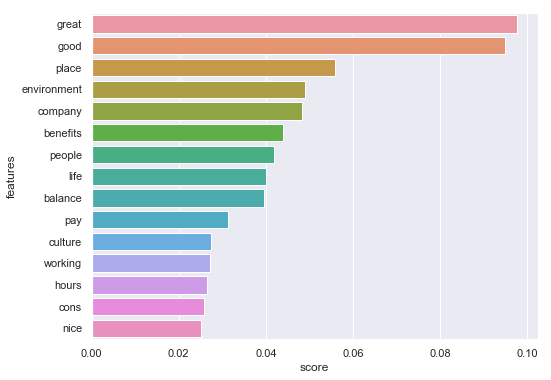

In [169]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

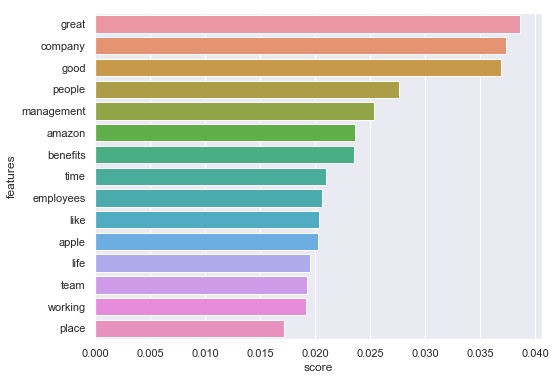

In [170]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

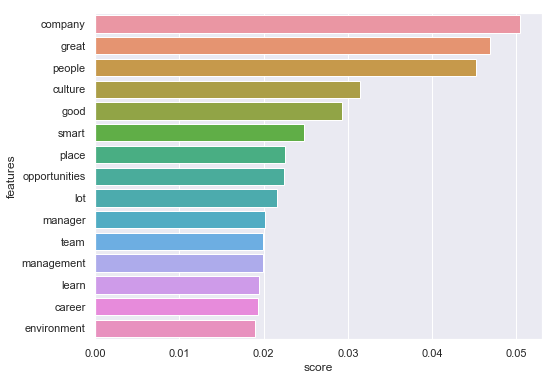

In [171]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

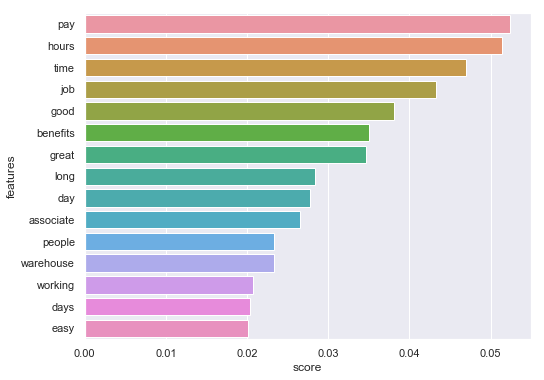

In [172]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[3][:15])

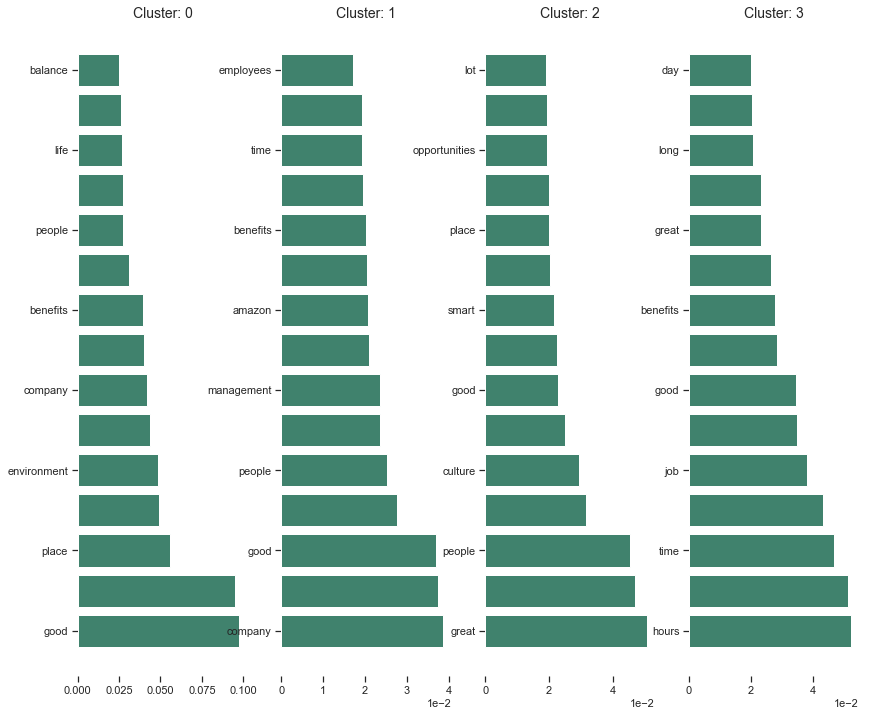

In [173]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)